In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, Dataset

In [3]:
from src.utils.__utils__ import *
from src.ssd.ssd_model import *
from src.config.prior_box_cfg_SSD300 import *
from src.transform import __imgtools__, __boxtools__, augmentation
from src.ssd import ssd_prior

from src.ssd.create_ssd import *

In [4]:
torch.cuda.set_device(2)

In [5]:
from torchvision import models
vgg16 = models.vgg16()

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
categories = {0: 'background', 1: 'microfiber'}
img_size = 300

In [6]:
# Make prior boxes (currently SSD300 only)
priors = __boxtools__.generate_ssd_priors(specs, image_size=img_size,
                                          clip=True)
priors = torch.from_numpy(priors).float()

In [7]:
# Load model
model = SSDNet(num_classes=2, im_shape=(img_size, img_size)).cuda()
p = "./model/microfiber_2019-05-28.pth"
load_model(model, p)

Inference time:  0.009730815887451172
tensor([]) tensor([])


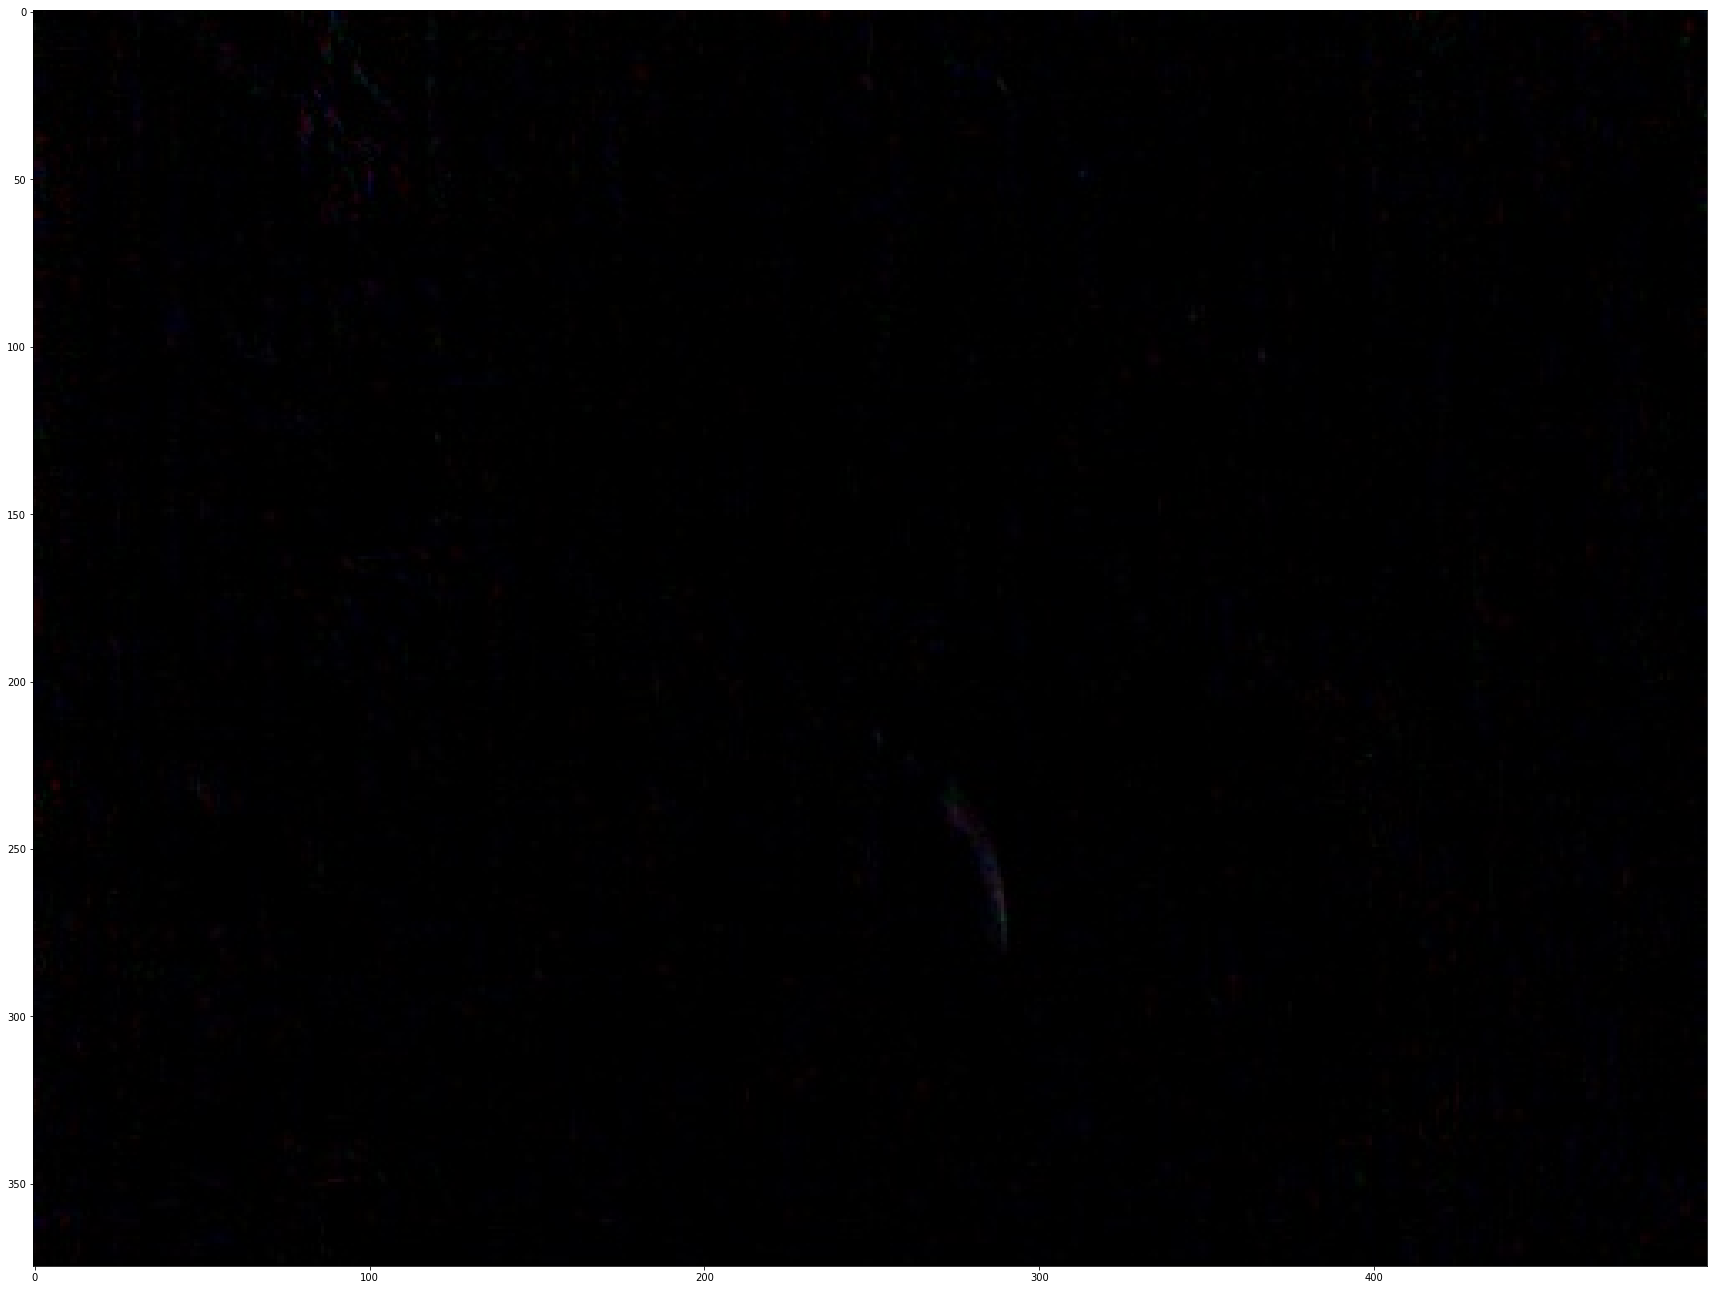

In [25]:
plt.rcParams['figure.figsize'] = (30, 30)
prob_thresh = 0.6

# prepare test image
image_path = '/data/xhan/Dropbox/USF MantaRay Data Share/Image Training Data/080618 Afternoon Station/Microfibers/271.jpeg'
orig_image = cv2.imread(image_path)
resized = cv2.resize(orig_image, (img_size, img_size))
image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
image = augmentation.normalize(image)
image = torch.from_numpy(image).permute([2, 0, 1]).float()

# create predictor and make prediction
predictor = create_vgg_ssd_predictor(model, priors.cpu(), candidate_size=500, iou_threshold=0.3,
                                     nms_method='hard')
boxes, labels, probs = predictor.predict(image, top_k=-1, prob_threshold=prob_thresh)
# if len(boxes) == 0:
#     boxes, labels, probs = predictor.predict(image, top_k=1,
#                                              prob_threshold=max(prob_thresh-0.05, 0.5))
print(labels, probs)

# text settings
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = .6
fontColor = (255, 0, 255)
lineType = 2

# draw prediction result
for i in range(boxes.size(0)):
    box = __boxtools__.center_hw(boxes[i, ...])
    box = __imgtools__.resize_bbox((img_size, img_size), box, (orig_image.shape[1], orig_image.shape[0]))
    if box.sum() == 0:
        continue
    print(box)
    cv2.rectangle(orig_image, (int(box[1]-10), int(box[0]-10)),
                  (int(box[3]+10), int(box[2]+10)), (255, 255, 0), 1)
    label = f"{categories[labels[i].item()]}: {probs[i].item():.4f}"
    cv2.putText(orig_image,
                label,
                (int(box[1]-5), int(box[2]+40)),
                font,
                fontScale,
                fontColor,
                lineType)
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
def cut_4(img):
    r, c, _ = img.shape
    # order: left-top, left-bottom, right-top, right-bottom
    crops = [img[:int(r/2), :int(c/2), :], img[int(r/2):, :int(c/2), :],
             img[:int(r/2), int(c/2):, :], img[int(r/2):, int(c/2):, :]]
    
    return crops

Inference time:  0.007942914962768555
Inference time:  0.00978994369506836
Inference time:  0.009582757949829102
Inference time:  0.005804300308227539
[ 92.   0. 112.  15.] tensor(0.5918) tensor(1.)
[187.   4. 204.  29.] tensor(0.5300) tensor(1.)


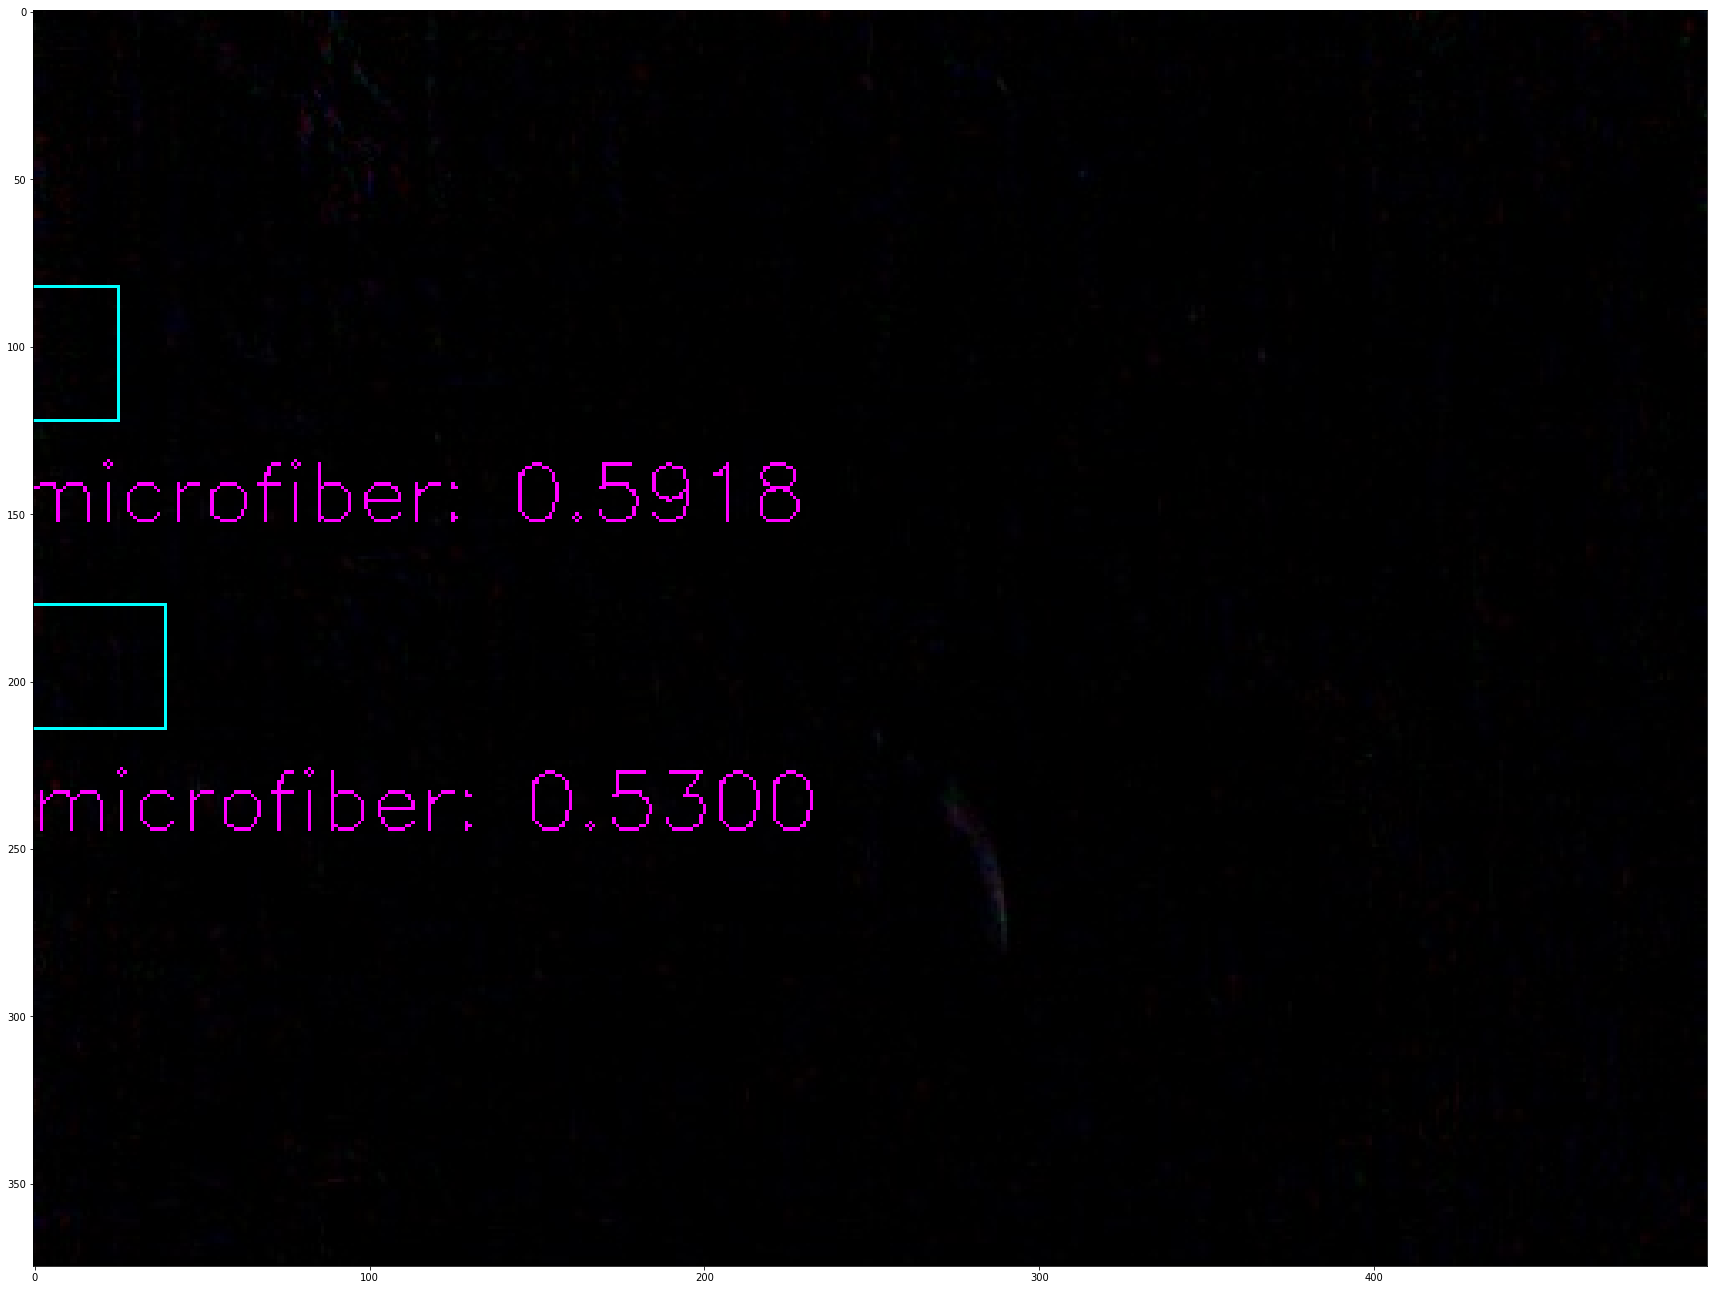

In [24]:
plt.rcParams['figure.figsize'] = (30, 30)
prob_thresh = 0.6

# prepare test image
image_path = '/data/xhan/Dropbox/USF MantaRay Data Share/Image Training Data/080618 Afternoon Station/Microfibers/271.jpeg'
orig_image = cv2.imread(image_path)

# ================================
small_images = cut_4(orig_image)
r, c, _ = orig_image.shape
put_back_boxes = []
for i, img in enumerate(small_images):
    resized = cv2.resize(img, (img_size, img_size))
    image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
    image = augmentation.normalize(image)
    image = torch.from_numpy(image).permute([2, 0, 1]).float()

    # create predictor and make prediction
    predictor = create_vgg_ssd_predictor(model, priors.cpu(), candidate_size=500, iou_threshold=0.3,
                                         nms_method='hard')
    boxes, labels, probs = predictor.predict(image, top_k=1, prob_threshold=prob_thresh-0.1)
    
    for j in range(boxes.size(0)):
        box = __boxtools__.center_hw(boxes[j, ...])
        box = __imgtools__.resize_bbox((img_size, img_size), box, (img.shape[1], img.shape[0]))
        if box.sum() == 0:
            continue
        
        if i == 0:
            put_back_boxes.append((box, probs[j], labels[j]))
        elif i == 1:
            put_back_boxes.append((box + np.array([int(r/2), 0, int(r/2), 0]), probs[j], labels[j]))
        elif i == 2:
            put_back_boxes.append((box + np.array([0, int(c/2), 0, int(c/2)]), probs[j], labels[j]))
        else:
            put_back_boxes.append((box + np.array([int(r/2), int(c/2), int(r/2), int(c/2)]), probs[j], labels[j]))

# text settings
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = .8
fontColor = (255, 0, 255)
lineType = 1

# draw prediction result
for box, prob, label in put_back_boxes:
    print(box, prob, label)
    cv2.rectangle(orig_image, (int(box[1]-10), int(box[0]-10)),
                  (int(box[3]+10), int(box[2]+10)), (255, 255, 0), 1)
    label = f"{categories[label.item()]}: {prob.item():.4f}"
    cv2.putText(orig_image,
                label,
                (int(box[1]-5), int(box[2]+40)),
                font,
                fontScale,
                fontColor,
                lineType)
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()